In [147]:
import torch
from torch import nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Step1: Data preparation/loading

In [148]:
weight = 0.7
bias = 0.3
X = torch.arange(start=0,end=1,step=0.02).unsqueeze(dim=1).to(device)
Y = (X * weight + bias).to(device)
X[:10],Y[:10],X.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 torch.Size([50, 1]))

In [149]:
# train/test split
split_point = int(0.8*len(X))
X_train, Y_train = X[:split_point], Y[:split_point]
X_test, Y_test = X[split_point:], Y[split_point:]
len(X_train), len(Y_train), len(X_test), len(Y_test)

(40, 40, 10, 10)

In [150]:
# visualize the data
def plot_predictions(train_data=X_train, 
                     train_labels=Y_train, 
                     test_data=X_test, 
                     test_labels=Y_train, 
                     predictions=None):
  plt.figure(figsize=(10, 7))
  sns.scatterplot(x=X_train.squeeze(),y=Y_train.squeeze())
  sns.scatterplot(x=X_test.squeeze(),y=Y_test.squeeze())

  if predictions is not None:
    sns.scatterplot(x=X_test.squeeze(),y=predictions.squeeze())


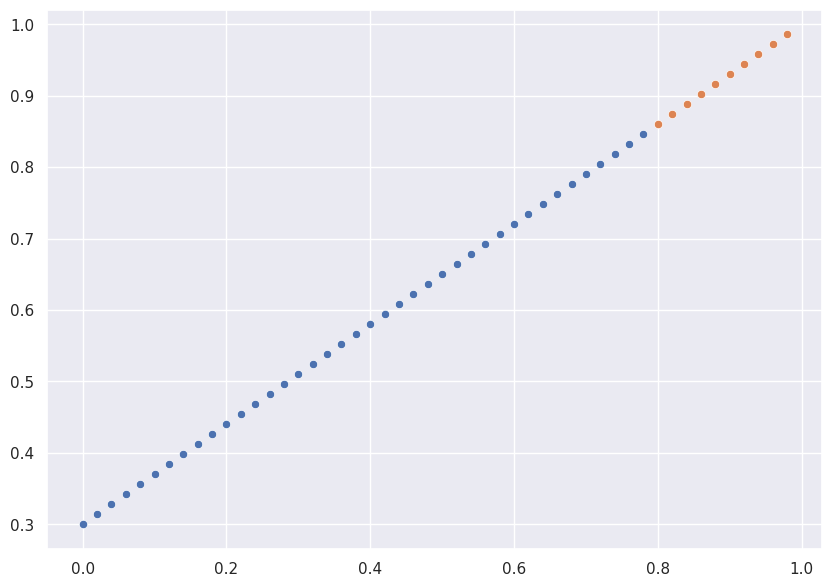

In [151]:
plot_predictions()

# Preparing the model

In [152]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(1,dtype=torch.float,requires_grad=True))
        self.bias = nn.Parameter(torch.rand(1,dtype=torch.float,requires_grad=True))
    
    def forward(self,x):
        return x * self.weight + self.bias
    
model0 = LinearRegression().to(device)

In [153]:
list(model0.parameters())

[Parameter containing:
 tensor([0.0290], requires_grad=True),
 Parameter containing:
 tensor([0.4144], requires_grad=True)]

In [154]:
model0.state_dict()

OrderedDict([('weight', tensor([0.0290])), ('bias', tensor([0.4144]))])

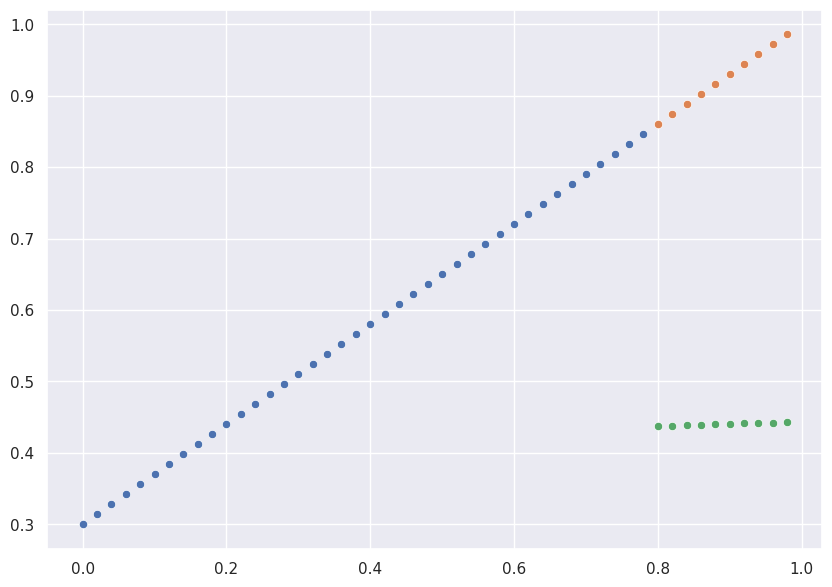

In [155]:
with torch.inference_mode():
    y_test_pred = model0(X_test)
    plot_predictions(predictions=y_test_pred)

# Train the model

In [156]:
optimizer = torch.optim.SGD(model0.parameters(),lr=1e-2)
loss_fn = nn.L1Loss()
EPOCHS = 100

train_loss_values = []
test_loss_values = []
epoch_counts = []
for epoch in range(EPOCHS):
    # train
    model0.train()
    Y_train_pred = model0(X_train)
    train_loss = loss_fn(Y_train_pred,Y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # test
    model0.eval()
    with torch.inference_mode():
        Y_test_pred = model0(X_test)
        test_loss = loss_fn(Y_test_pred,Y_test)
        if epoch % 10 == 0:
            epoch_counts.append(epoch)
            train_loss_values.append(train_loss.item())
            test_loss_values.append(test_loss.item())
            print(f"Epoch: {epoch} | MAE Train Loss: {train_loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.17458215355873108 | MAE Test Loss: 0.47407540678977966 
Epoch: 10 | MAE Train Loss: 0.1429063081741333 | MAE Test Loss: 0.4011163115501404 
Epoch: 20 | MAE Train Loss: 0.12661078572273254 | MAE Test Loss: 0.34890422224998474 
Epoch: 30 | MAE Train Loss: 0.11773320287466049 | MAE Test Loss: 0.31196731328964233 
Epoch: 40 | MAE Train Loss: 0.11211465299129486 | MAE Test Loss: 0.2854956090450287 
Epoch: 50 | MAE Train Loss: 0.10792102664709091 | MAE Test Loss: 0.26702648401260376 
Epoch: 60 | MAE Train Loss: 0.10414502769708633 | MAE Test Loss: 0.2526165843009949 
Epoch: 70 | MAE Train Loss: 0.10065500438213348 | MAE Test Loss: 0.24159681797027588 
Epoch: 80 | MAE Train Loss: 0.09716498851776123 | MAE Test Loss: 0.23057691752910614 
Epoch: 90 | MAE Train Loss: 0.09367499500513077 | MAE Test Loss: 0.21955685317516327 


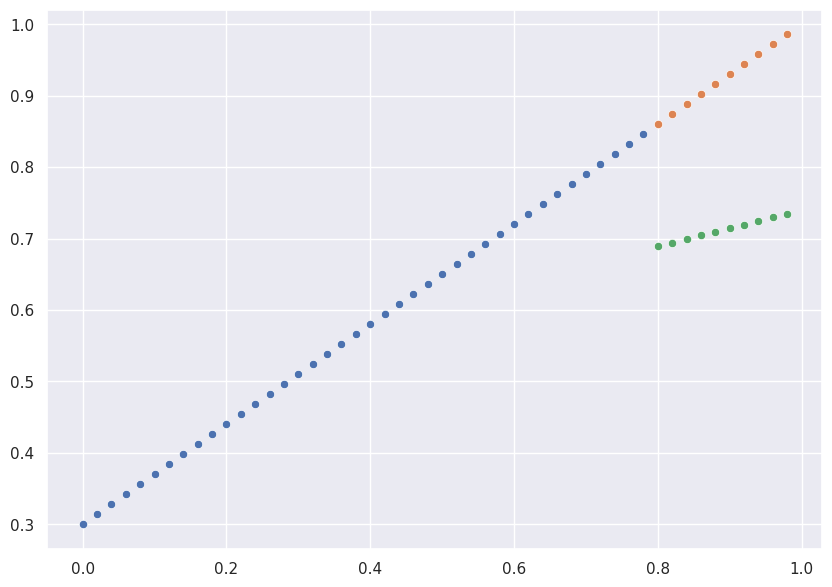

In [157]:
with torch.inference_mode():
    y_test_pred = model0(X_test)
    plot_predictions(predictions=y_test_pred)

In [158]:
def plot_loss_curve(epochs,train_loss_values,test_loss_values):
    print(type(epochs))
    print(type(train_loss_values))
    print(type(test_loss_values))
    sns.lineplot(x=epochs,y=train_loss_values)
    sns.lineplot(x=epochs,y=test_loss_values)

<class 'list'>
<class 'list'>
<class 'list'>


([0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
 [0.17458215355873108,
  0.1429063081741333,
  0.12661078572273254,
  0.11773320287466049,
  0.11211465299129486,
  0.10792102664709091,
  0.10414502769708633,
  0.10065500438213348,
  0.09716498851776123,
  0.09367499500513077],
 [0.47407540678977966,
  0.4011163115501404,
  0.34890422224998474,
  0.31196731328964233,
  0.2854956090450287,
  0.26702648401260376,
  0.2526165843009949,
  0.24159681797027588,
  0.23057691752910614,
  0.21955685317516327])

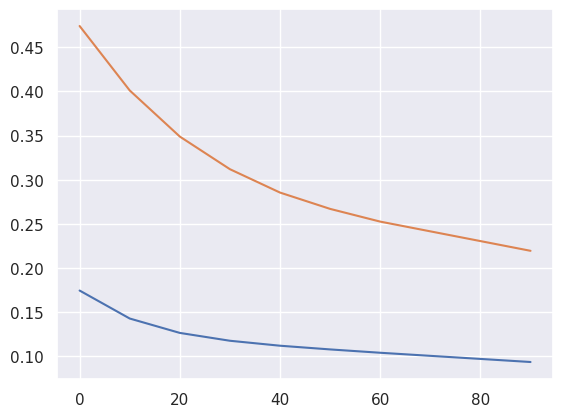

In [159]:
plot_loss_curve(epoch_counts,train_loss_values,test_loss_values)
epoch_counts,train_loss_values,test_loss_values


# Save and Load Model

In [160]:
from pathlib import Path

with torch.inference_mode():
    y_preds = model0(X_test)

MODEL_PATH = Path("models/regression_v0.pt")

torch.save(model0.state_dict(),MODEL_PATH)
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegression()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_PATH))
# 1. Put the loaded model into evaluation mode

loaded_model_0.eval()
# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])